In [1]:
import tensorflow as tf
import numpy as np
import h5py

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from lib.autoencoder import Autoencoder
from lib.data import load_dataset, prepare_images_tensorflow, normalize_single_images
from lib.theory import TheoryPhaseDiagram

# Parameter
Set here some parameters

In [2]:
# Set this to true to train the network and save it to disk. Otherwise the network will be loaded from disk
save_networks = False

# Load and prepare data
Here we load the corresponding data. The data gets normalized to a domain between 0 and 1 for each image individually. Furthermore we split teh data in a validation and test set.

In [3]:
data_source = 'data/phase_diagram_56.h5'

images, parameter = load_dataset(data_source, {'freq', 'hold', 'micromotion_phase', 'phase'})
IMAGE_SIZE = images.shape[1]
number_of_images = len(images)
# prepare the data
images = normalize_single_images(images)
images = prepare_images_tensorflow(images)

validation_split = int(number_of_images * 0.1)

complete_ds = tf.data.Dataset.from_tensor_slices((images, images)).shuffle(number_of_images)

batch_size = 40

validation_dataset = complete_ds.take(validation_split).batch(300).prefetch(tf.data.experimental.AUTOTUNE)
train_dataset = complete_ds.skip(validation_split).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Set up the model
Here we setup the model. We use the implementation of the autoencoder that can be found in lib/autoencoder.

In [4]:
if save_networks:
    encoder = tf.keras.models.Sequential(
        [
            tf.keras.layers.InputLayer((IMAGE_SIZE, IMAGE_SIZE, 1)),

            tf.keras.layers.Conv2D(64, 2, padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(2, strides=2, padding='same'),

            tf.keras.layers.Conv2D(32, 2, padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(2, strides=2, padding='same'),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(2),
        ])
    decoder = tf.keras.models.Sequential(
    [
        tf.keras.layers.InputLayer((2,)),
        tf.keras.layers.Dense(14**2, activation='relu'),
        
        tf.keras.layers.Reshape((14, 14, 1)),
        
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.UpSampling2D(2),
        
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.UpSampling2D(2),
        
        tf.keras.layers.Conv2D(1, 2, padding='same', activation='tanh'),
    ])
else:
    encoder = tf.keras.models.load_model('trained_networks/IIIa_encoder.h5')
    decoder = tf.keras.models.load_model('trained_networks/IIIa_decoder.h5')

In [5]:
model = Autoencoder(encoder, decoder)

In [6]:
model.encoder.summary()
model.decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 12546     
Total params: 21,090
Trainable params: 21,090
Non-trainable params: 0
____________________________________________________

# Training of the autoencoder
Here we train the autoencoder with keras fit function.

In [7]:
if save_networks:
    lr = 0.001

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

    history = model.fit(
        train_dataset,
        epochs=100,
        shuffle=True,
        validation_data=validation_dataset,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=8)
        ],
        verbose=True)
    
    model.encoder.save('trained_networks/IIIa_encoder.h5')
    model.decoder.save('trained_networks/IIIa_decoder.h5')
    
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['loss'])
    plt.grid()
    plt.savefig('plots/IIIa/training_history.eps', bbox_inches='tight')
    plt.show()

# Calculate latent space and reconstructed images

In [8]:
reconstructed_images = np.squeeze(model.predict(images, batch_size=100))
latent_space = model.encoder.predict(images, batch_size=100)

In [9]:
latent_space.shape

(10436, 2)

Set some general properties to let all figures look similar.

In [10]:
phase_ticks = np.arange(-180, 181, 45)
freq_limit_low = 5.1
freq_limit_high = 7.8

In [11]:
face_colors = {
    'orange': [0.8906, 0.4609, 0.4062],
    'gray': [0.6523, 0.6484, 0.6484],
    'blue': [0.5156, 0.5977, 0.8789]
}
edge_colors = {
    'orange': [0.9961, 0, 0],
    'gray': [0.4805, 0.4766, 0.4766],
    'blue': [0, 0, 0.9961]
}

edge_colors_arr = [ec for ec in edge_colors.values()]
face_colors_arr = [fc for fc in face_colors.values()]

cycler = (plt.cycler(mec=edge_colors_arr)+
          plt.cycler(mfc=face_colors_arr)+
          plt.cycler(color=edge_colors_arr))

In [12]:
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 24,
    'lines.markeredgewidth': 2,
    'lines.markersize': 9,
    'lines.marker': 'o',
    'lines.linestyle': '',
    'lines.linewidth': 3,
    'axes.prop_cycle': cycler
    })

# Prepare theory data

In [13]:
theory_phase_diagram = TheoryPhaseDiagram('data/phase_diagram_theory.h5')

# Plot all bottleneck activations
This plot is used in figure 2.

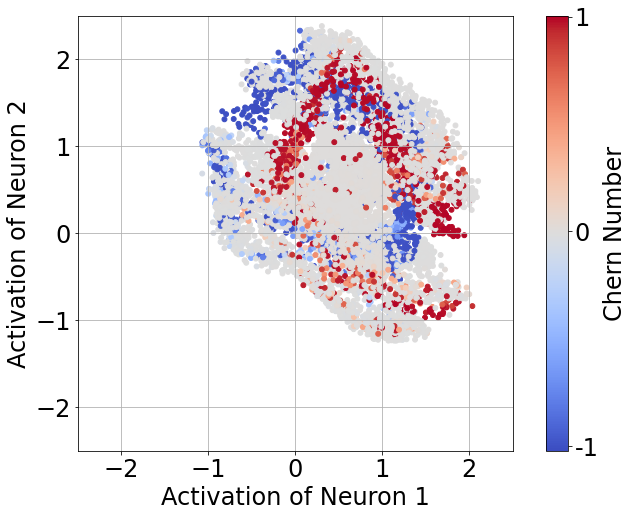

In [16]:
x = latent_space[:, 0]
y = latent_space[:, 1]
phases = parameter['phase']
freqs = parameter['freq']
theory_pred = theory_phase_diagram.get_theory_predictions(freqs, phases)

ax = plt.subplot()
ax.set_aspect('equal', 'box')
plt.scatter(x, y, 24, theory_pred, 'o', cmap='coolwarm', rasterized=True)
plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
cbar = plt.colorbar(ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['-1', '0', '1'])
cbar.ax.set_ylabel('Chern Number')
plt.xlabel('Activation of Neuron 1')
plt.ylabel('Activation of Neuron 2')
plt.grid()
plt.savefig('plots/IIIa/complete_bottleneck_theory_color.eps', bbox_inches='tight')
plt.show()

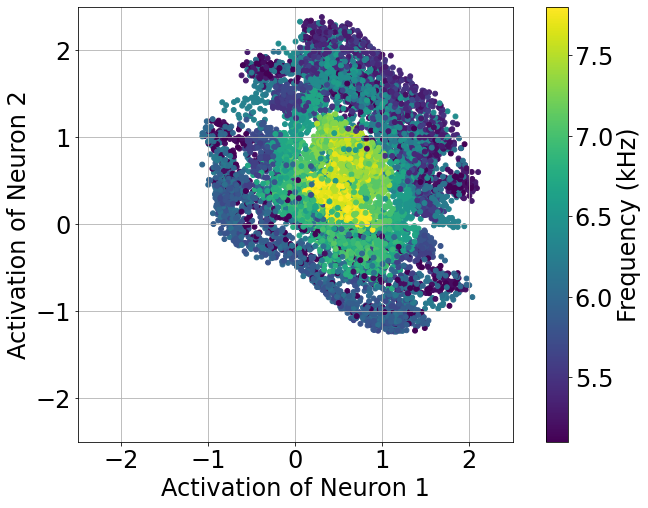

In [15]:
x = latent_space[:, 0]
y = latent_space[:, 1]
phases = parameter['phase']
freqs = parameter['freq']
theory_pred = theory_phase_diagram.get_theory_predictions(freqs, phases)

ax = plt.subplot()
ax.set_aspect('equal', 'box')
plt.scatter(x, y, 24, freqs, 'o', cmap='viridis', rasterized=True)
plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Frequency (kHz)')
plt.xlabel('Activation of Neuron 1')
plt.ylabel('Activation of Neuron 2')
plt.grid()
plt.savefig('plots/IIIa/complete_bottleneck_freq_color.eps', bbox_inches='tight')
plt.show()

# Plot cut along a fixed shaking frequency
This figure is used in the appendix

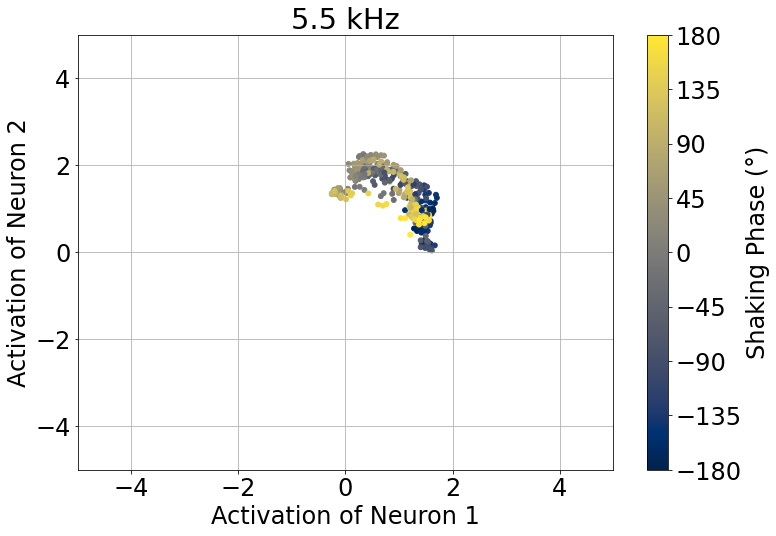

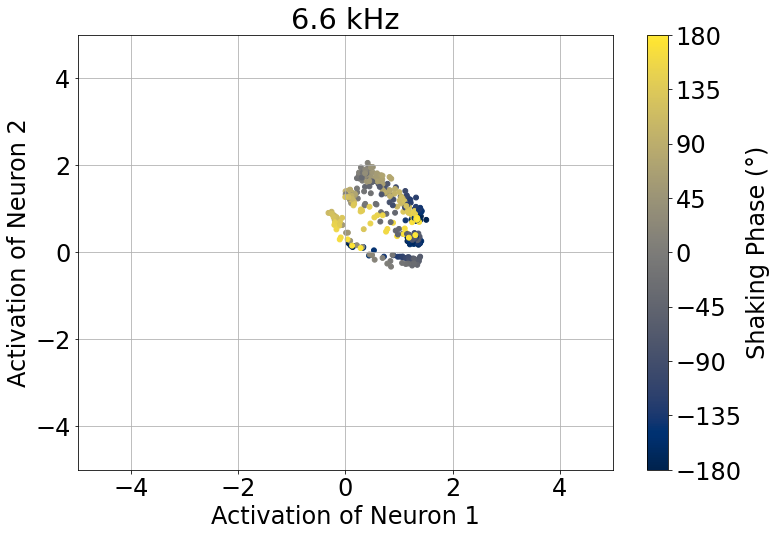

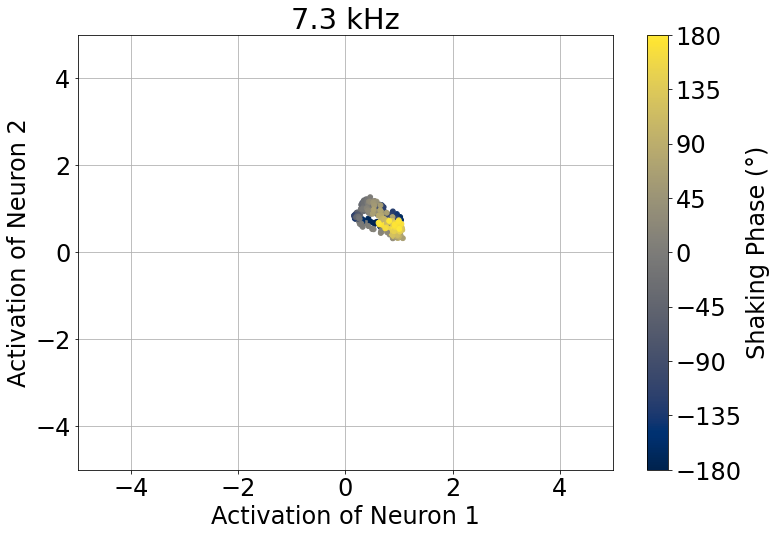

In [16]:
frequency_selection = [5.5, 6.6, 7.3]
for s_freq in frequency_selection:
    selection_map = parameter['freq'] == s_freq
    x = latent_space[selection_map, 0]
    y = latent_space[selection_map, 1]
    phases = parameter['phase'][selection_map]
    freqs = parameter['freq'][selection_map]

    plt.scatter(x, y, 24, phases, 'o', cmap='cividis', rasterized=True)
    plt.xlim([-5.0, 5.0])
    plt.ylim([-5.0, 5.0])
    cbar = plt.colorbar(ticks=phase_ticks)
    cbar.ax.set_ylabel('Shaking Phase (°)')
    plt.xlabel('Activation of Neuron 1')
    plt.ylabel('Activation of Neuron 2')
    plt.title('{} kHz'.format(s_freq))
    plt.grid()
    plt.savefig('plots/IIIa/freq_cut_{}.eps'.format(s_freq), bbox_inches='tight')
    plt.show()

# Analyse the bottleneck activations for fixed shaking phase cuts

In [17]:
def fit_ellipse(x, y):
    # transpose
    x = x[:,None]
    y = y[:,None]

    # Fit the ellipse
    D = np.hstack([x*x,x*y,y*y,x,y,np.ones(x.shape)])
    S = np.dot(D.T,D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0]=2
    C[1,1] = -1
    E, V = np.linalg.eig(np.dot(np.linalg.inv(S), C))

    n = np.argmax(E)
    a = V[:,n]

    # Calculate parameters of the ellipse
    b, c, d, f, g, a = a[1]/2., a[2], a[3]/2., a[4]/2., a[5], a[0]
    num = b * b - a * c
    cx = (c * d - b * f) / num
    cy = (a * f - b * d) / num

    angle = 0.5 * np.arctan(2 * b / (a - c)) * 180 / np.pi
    up = 2 * (a * f * f + c * d * d + g * b * b - 2 * b * d * f - a * c * g)
    down1 = (b * b - a * c) * ( (c - a) * np.sqrt(1 + 4 * b * b / ((a - c) * (a - c))) - (c + a))
    down2 = (b * b - a * c) * ( (a - c) * np.sqrt(1 + 4 * b * b / ((a - c) * (a - c))) - (c + a))
    a = np.sqrt(abs(up / down1))
    b = np.sqrt(abs(up / down2))
    
    return cx , cy, a, b, angle

In [18]:
def get_ellipse_contour(cx , cy, a, b, angle):
    ell = Ellipse((cx, cy), a * 2., b * 2., angle)
    return ell.get_verts()

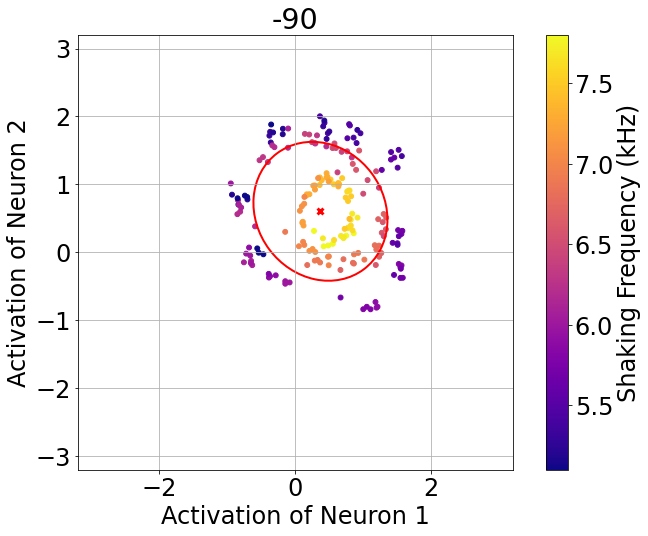

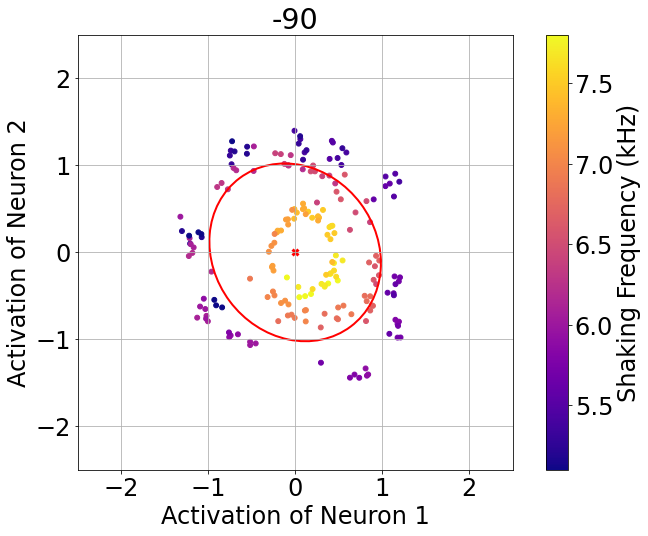

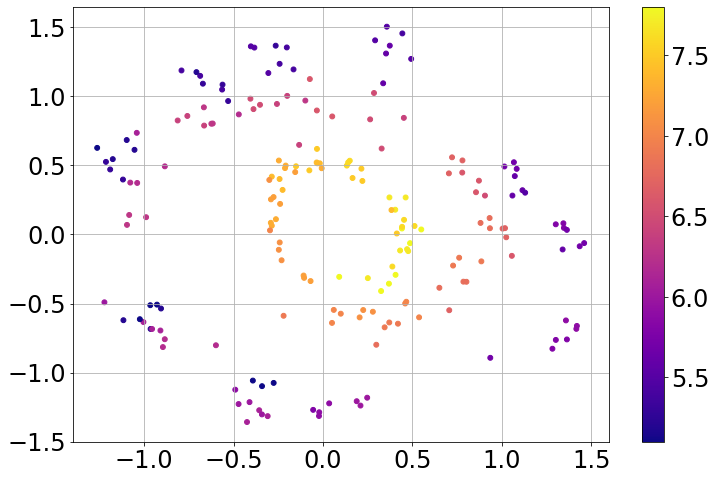

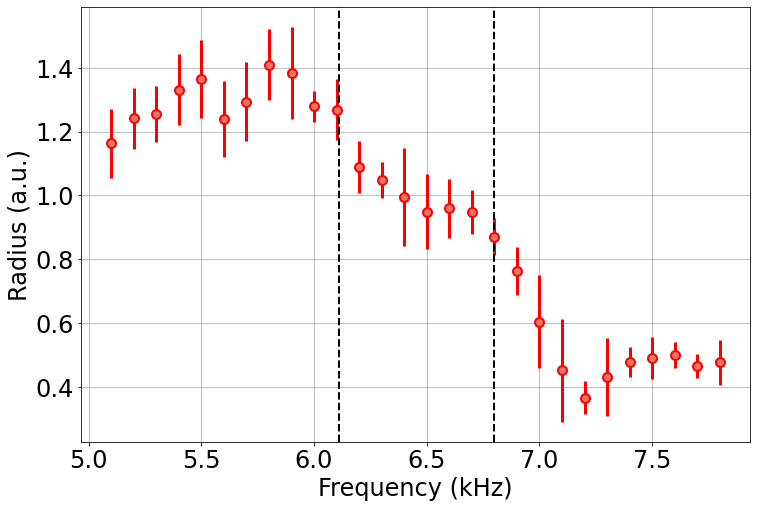

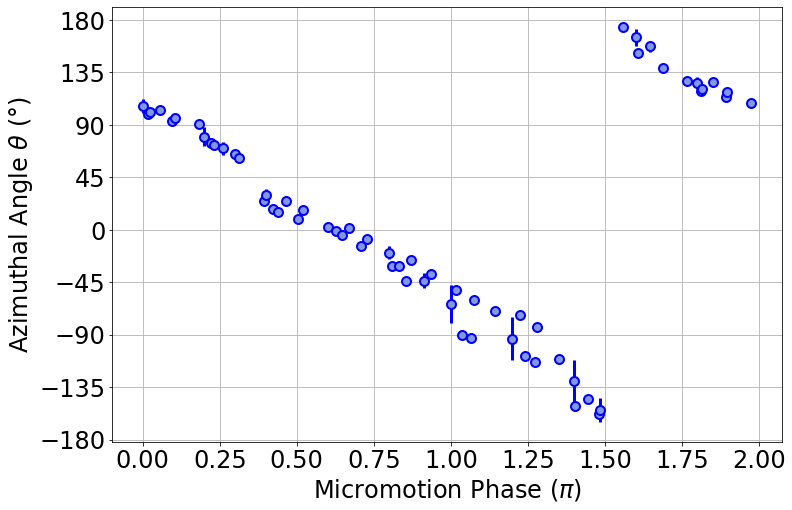

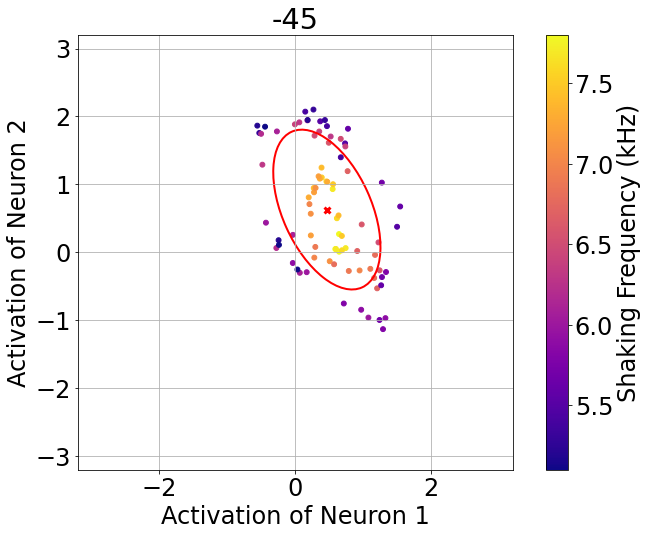

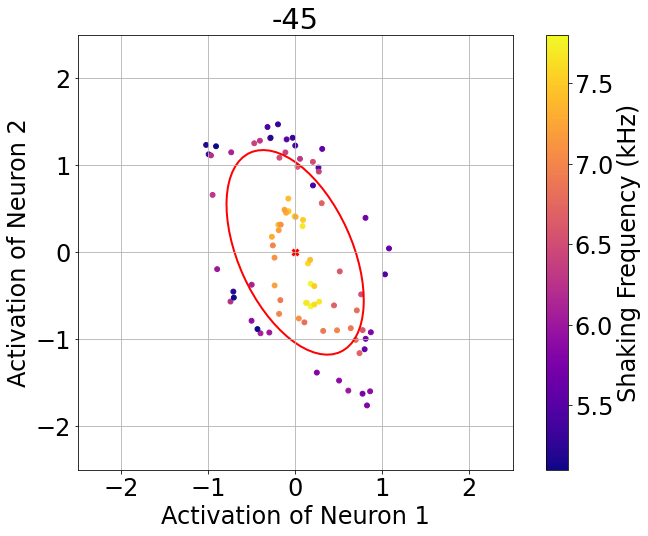

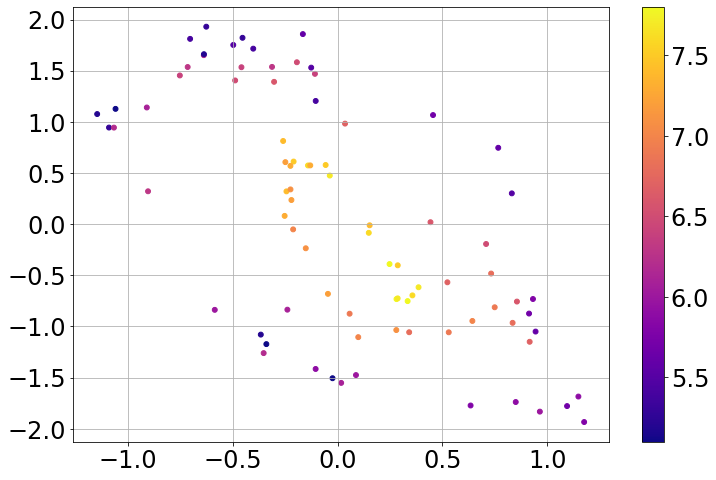

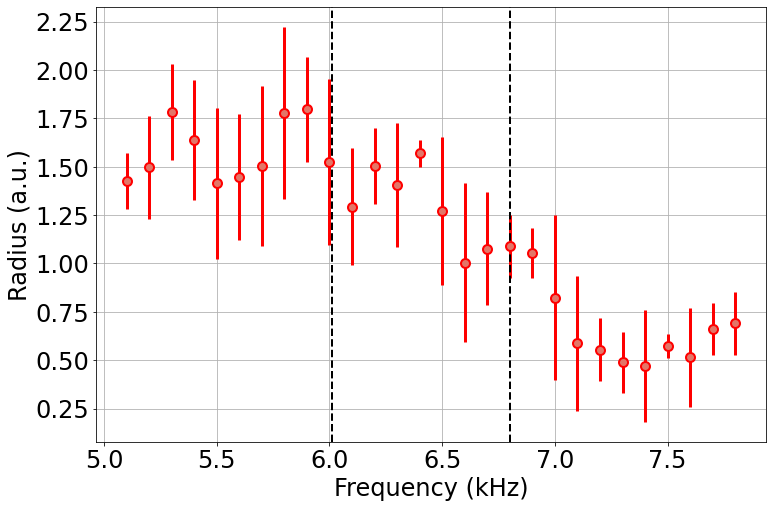

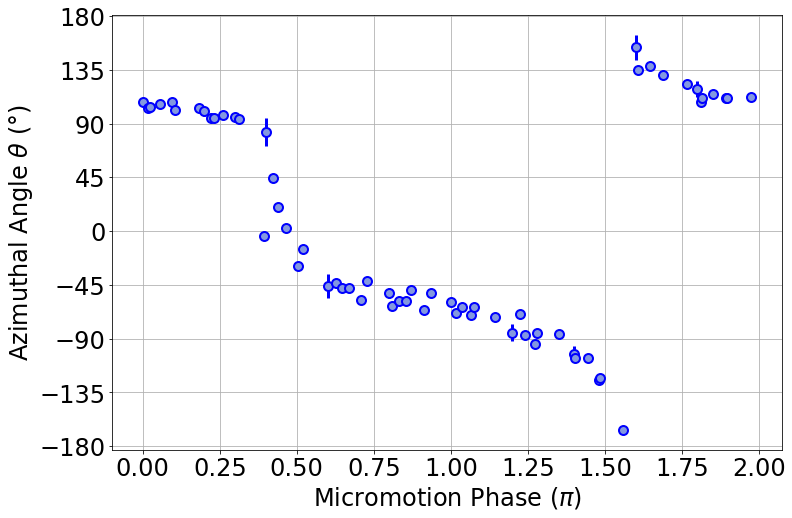

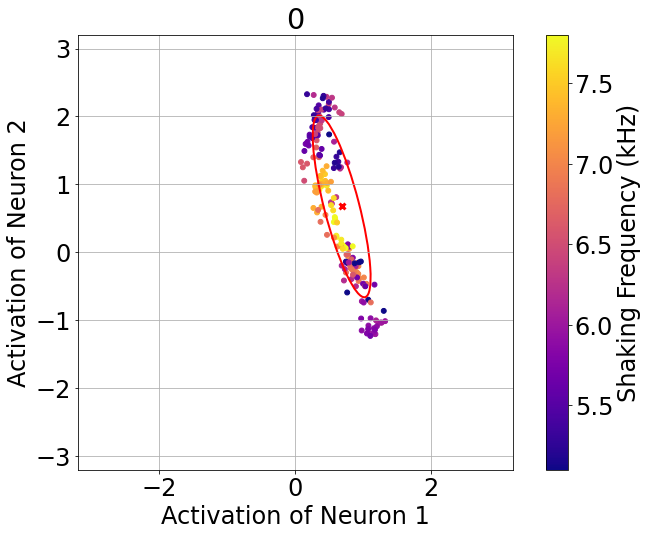

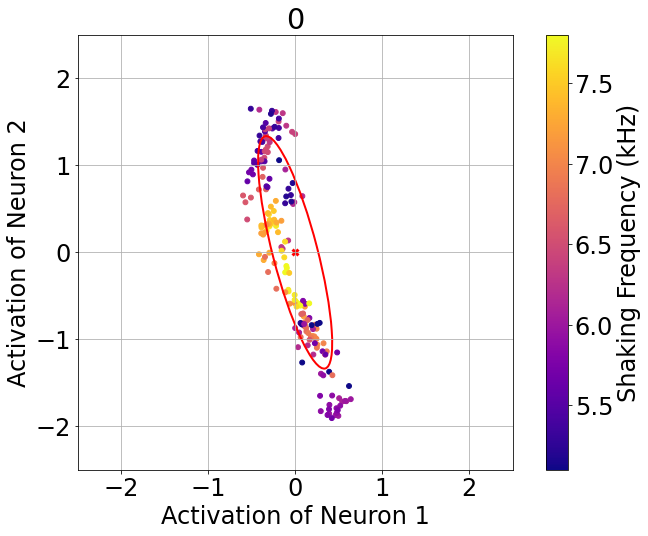

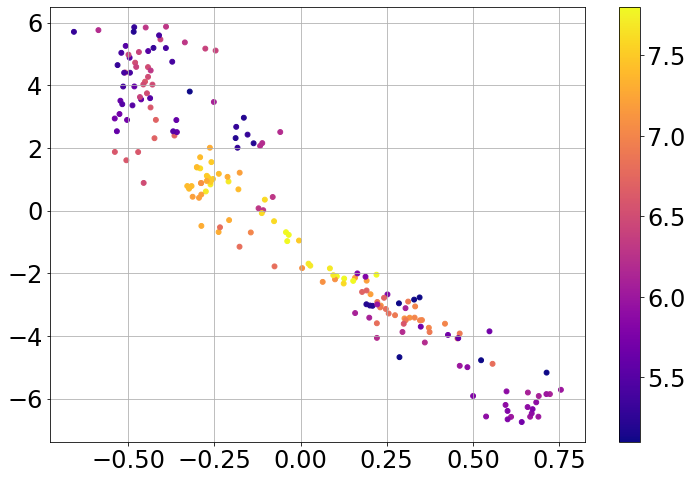

No theory transition.


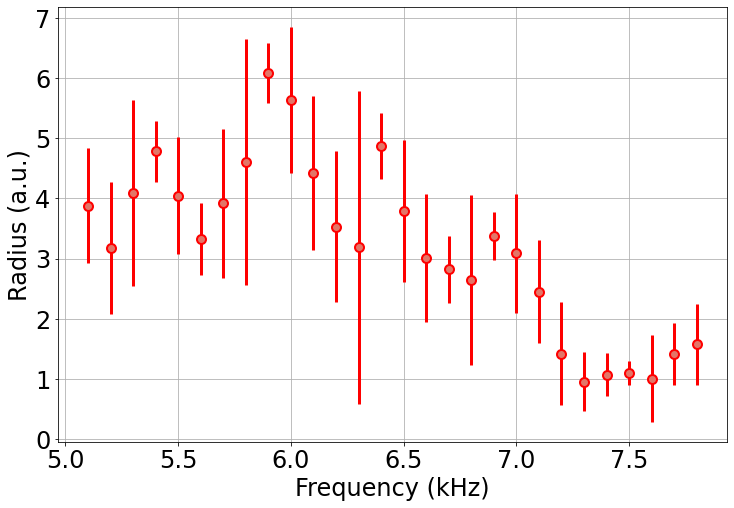

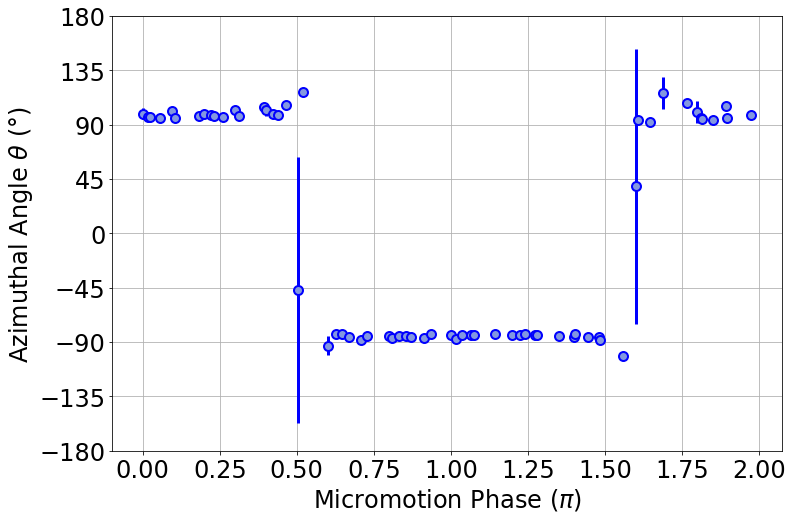

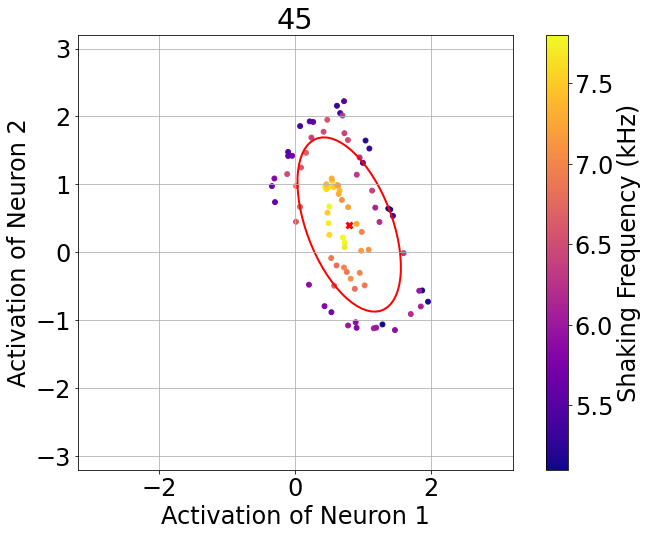

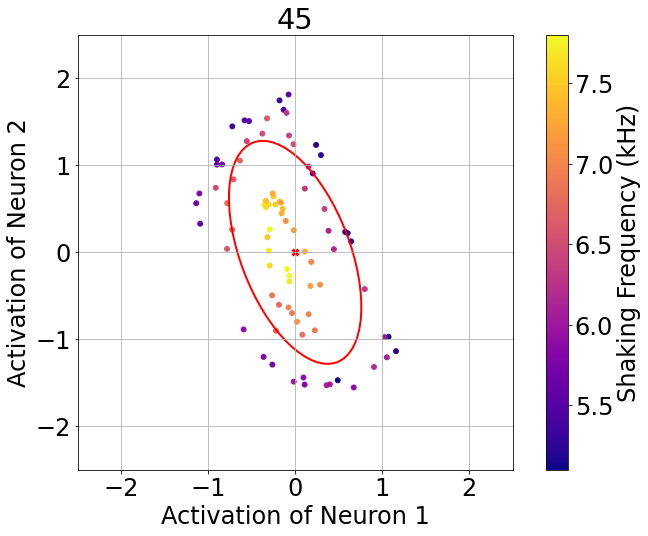

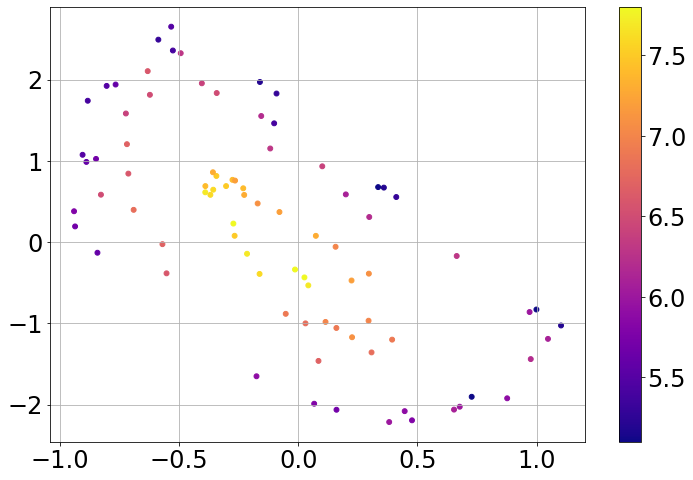

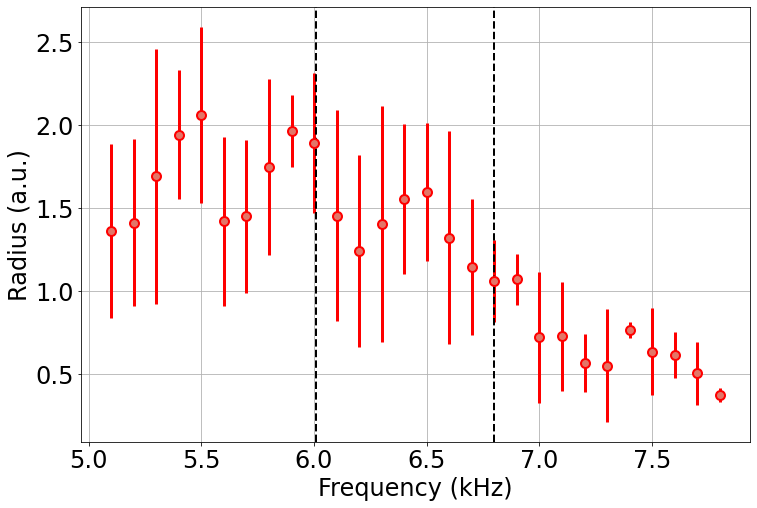

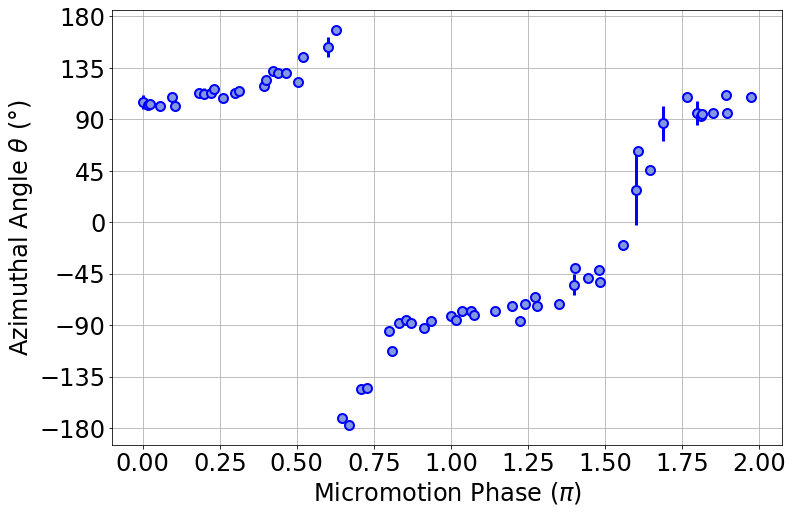

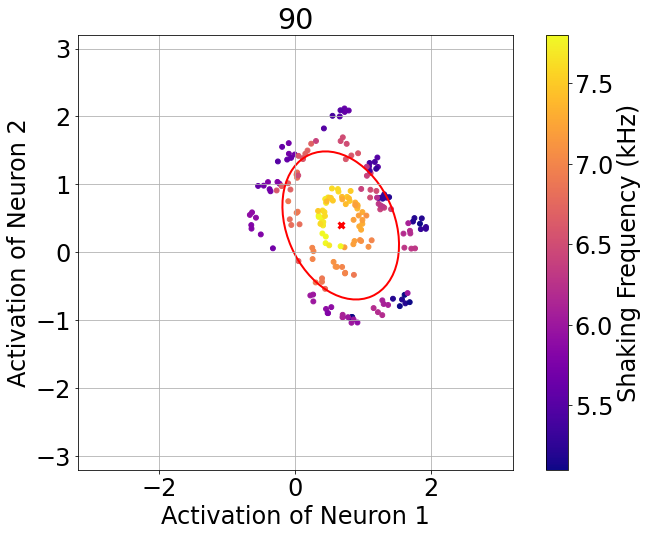

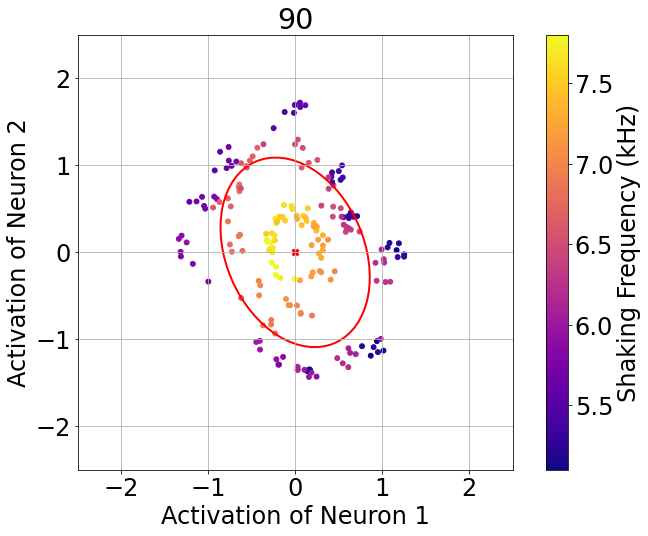

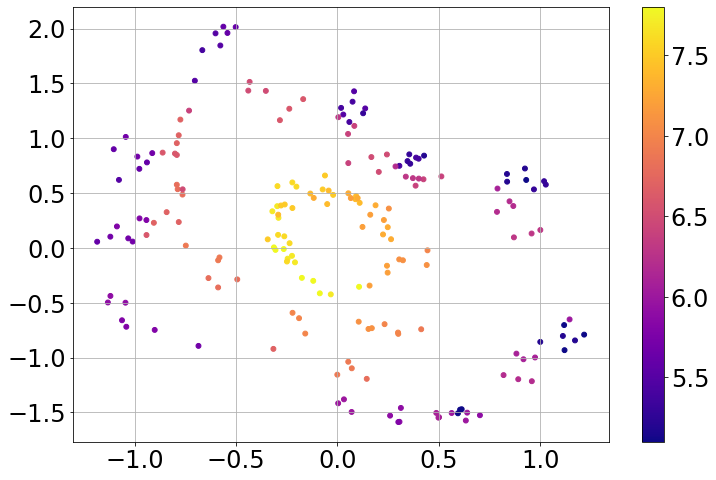

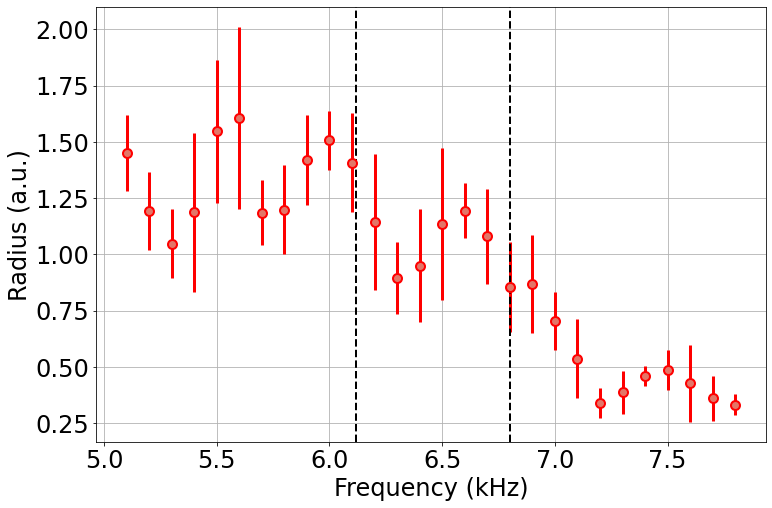

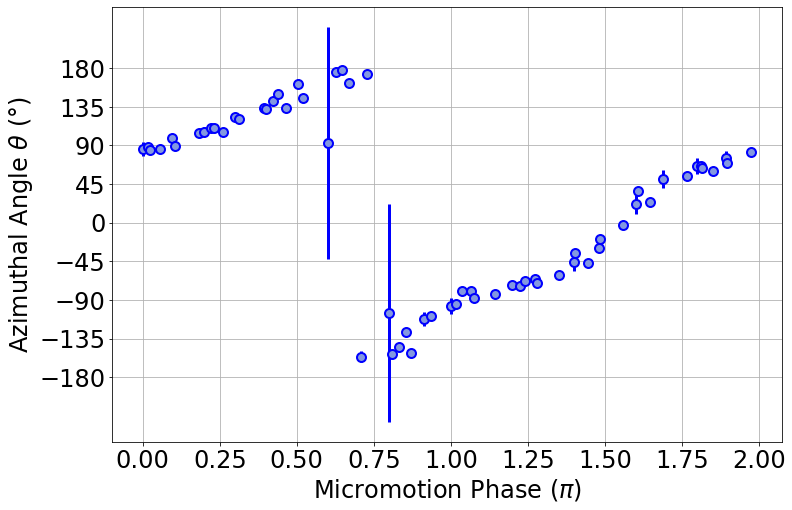

In [19]:
select_phases = [-90, -45, 0, 45, 90]
for phase in select_phases:
    selection_map = parameter['phase'] == phase
    x = latent_space[selection_map, 0]
    y = latent_space[selection_map, 1]
    freqs = parameter['freq'][selection_map]
    mm_phases = parameter['micromotion_phase'][selection_map]
    
    center_x , center_y, a, b, angle_deg = fit_ellipse(x, y)
    angle = angle_deg * np.pi / 180
    
    # shift the data to ellipse center
    x_shifted = x - center_x
    y_shifted = y - center_y
    latent_space_shifted = np.vstack([x_shifted, y_shifted])
    
    # rotate data
    rot_mat = np.array([[np.cos(angle), -np.sin(angle)],
                       [np.sin(angle), np.cos(angle)]])
    latent_space_rot = np.matmul(rot_mat, latent_space_shifted)
    
    x_shifted_norm = latent_space_rot[0, :] / b
    y_shifted_norm = latent_space_rot[1, :] / a

    # calculate polar coordinates
    radii = np.sqrt(x_shifted_norm**2 + y_shifted_norm**2)
    theta = np.arctan2(y_shifted_norm, x_shifted_norm)*180/np.pi
    
    # calculate mean values
    unique_freqs = np.unique(freqs)
    mean_radii = []
    std_radii = []
    for ufreq in unique_freqs:
        mean_radii.append(np.mean(radii[ufreq == freqs]))
        std_radii.append(np.std(radii[ufreq == freqs]))
    unique_mm_phases = np.unique(mm_phases)
    mean_theta = []
    std_theta = []
    for ummphase in unique_mm_phases:
        mean_theta.append(np.mean(theta[ummphase == mm_phases]))
        std_theta.append(np.std(theta[ummphase == mm_phases]))
    
    
    # plot original data with ellipse
    ellipse = Ellipse((center_x, center_y), a * 2., b * 2., angle_deg,
                      fill=False, color='r', linewidth=2)
    ax = plt.subplot()
    ax.add_patch(ellipse)
    ax.set_aspect('equal', 'box')
    plt.scatter(center_x, center_y, 35, color='red', marker='x')
    plt.scatter(x, y, 24, freqs, 'o', cmap='plasma')
    plt.xlabel('Activation of Neuron 1')
    plt.ylabel('Activation of Neuron 2')
    plt.title(phase)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Shaking Frequency (kHz)')
    plt.xlim([-3.2, 3.2])
    plt.ylim([-3.2, 3.2])
    plt.grid()
    plt.savefig('plots/IIIa/phase_cut_ellipse_{}.eps'.format(phase), bbox_inches='tight')
    plt.show()
    
    # plot shifted data with ellipse
    ellipse = Ellipse((0, 0), a * 2., b * 2., angle_deg,
                      fill=False, color='r', linewidth=2)
    ax = plt.subplot()
    ax.add_patch(ellipse)
    ax.set_aspect('equal', 'box')
    plt.scatter(0, 0, 35, color='red', marker='x')
    plt.scatter(x_shifted, y_shifted, 24, freqs, 'o', cmap='plasma')
    plt.xlabel('Activation of Neuron 1')
    plt.ylabel('Activation of Neuron 2')
    plt.title(phase)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Shaking Frequency (kHz)')
    plt.xlim([-2.5, 2.5])
    plt.ylim([-2.5, 2.5])
    plt.grid()
    plt.savefig('plots/IIIa/phase_cut_ellipse_shifted_{}.eps'.format(phase), bbox_inches='tight')
    plt.show()

    # plot shifted data
    plt.scatter(x_shifted_norm, y_shifted_norm, 24, freqs, 'o', cmap='plasma')
    plt.colorbar()
    plt.grid()
    plt.savefig('plots/IIIa/phase_cut_ellipse_transform_{}.eps'.format(phase), bbox_inches='tight')
    plt.show()
    
    # radius plots
    try:
        lower_transition, upper_transition = theory_phase_diagram.get_theory_transitions(phase)
        plt.axvline(lower_transition, ls='--', marker=None, color='black', ms=0, linewidth=2.0)
        plt.axvline(upper_transition, ls='--', marker=None, color='black', ms=0, linewidth=2.0)
    except:
        print('No theory transition.')
    plt.errorbar(unique_freqs, mean_radii, std_radii)
    plt.xlabel('Frequency (kHz)')
    plt.ylabel('Radius (a.u.)')
    #plt.title(phase)
    plt.grid()
    plt.savefig('plots/IIIa/radius_{}.eps'.format(phase), bbox_inches='tight')
    plt.show()
    
    # theta plots
    plt.errorbar(unique_mm_phases/np.pi, mean_theta, std_theta,
                 mec=edge_colors['blue'], mfc=face_colors['blue'], color=edge_colors['blue'])
    plt.xlabel('Micromotion Phase ($\pi$)')
    plt.xticks(np.arange(0, 2.25, 1/4))
    plt.ylabel(r'Azimuthal Angle $\theta$ (°)')
    plt.yticks(np.arange(-180, 225, 45))
    #plt.title(phase)
    plt.grid()
    plt.savefig('plots/IIIa/theta_{}.eps'.format(phase), bbox_inches='tight')
    plt.show()